In [1]:
#Setup and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings


#configuration
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
plt.style.use('seaborn-v0_8')

#constants 
DATA_PATH = Path("dataset/train.csv")
VIZ_PATH = Path("visualizations")
VIZ_PATH.mkdir(exist_ok=True)

COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#8E44AD', '#27AE60']

In [2]:
#Utility Functions

def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded: {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data(DATA_PATH)


def get_missing_summary(df):
    missing_data = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            missing_data.append({
                'feature' : col,
                'missing_count' : df[col].isnull().sum(),
                'missing_pct' : round(df[col].isnull().mean() * 100, 2)
            })
    
    if missing_data:
        return pd.DataFrame(missing_data).sort_values('missing_pct', ascending=False)
    return pd.DataFrame()

missing_summary = get_missing_summary(df)

features = missing_summary['feature'].tolist()

def plot_missing_impact(df, features, target='SalePrice' , max_features = 6):
    features_to_plot = features[:max_features]

    fig,axes = plt.subplots(2,3, figsize=(15,16))
    fig.suptitle('Missing Values Impact on Sale Price', fontsize=14)
    axes = axes.ravel()

    for i,feature in enumerate(features_to_plot):
        data = df.copy()
        data['is_missing'] = data[feature].isnull().astype(int)

        median_prices = data.groupby('is_missing')[target].sum()

        axes[i].bar(['Present', 'Missing'],
                   [median_prices[0], median_prices[1]],
                   color = COLORS[:2])
        axes[i].set_title(feature)
        axes[i].set_ylabel('Median Price')

    for j, v in enumerate([median_prices[0], median_prices[1]]):
        axes[i].text(j, v, f'${v:,.0f}', ha='center', va='bottom')

    for i in range(len(features_to_plot), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig(VIZ_PATH / 'missing_impact.png', dpi=300, bbox_inches='tight')
    plt.show()


Data loaded: (1460, 81)


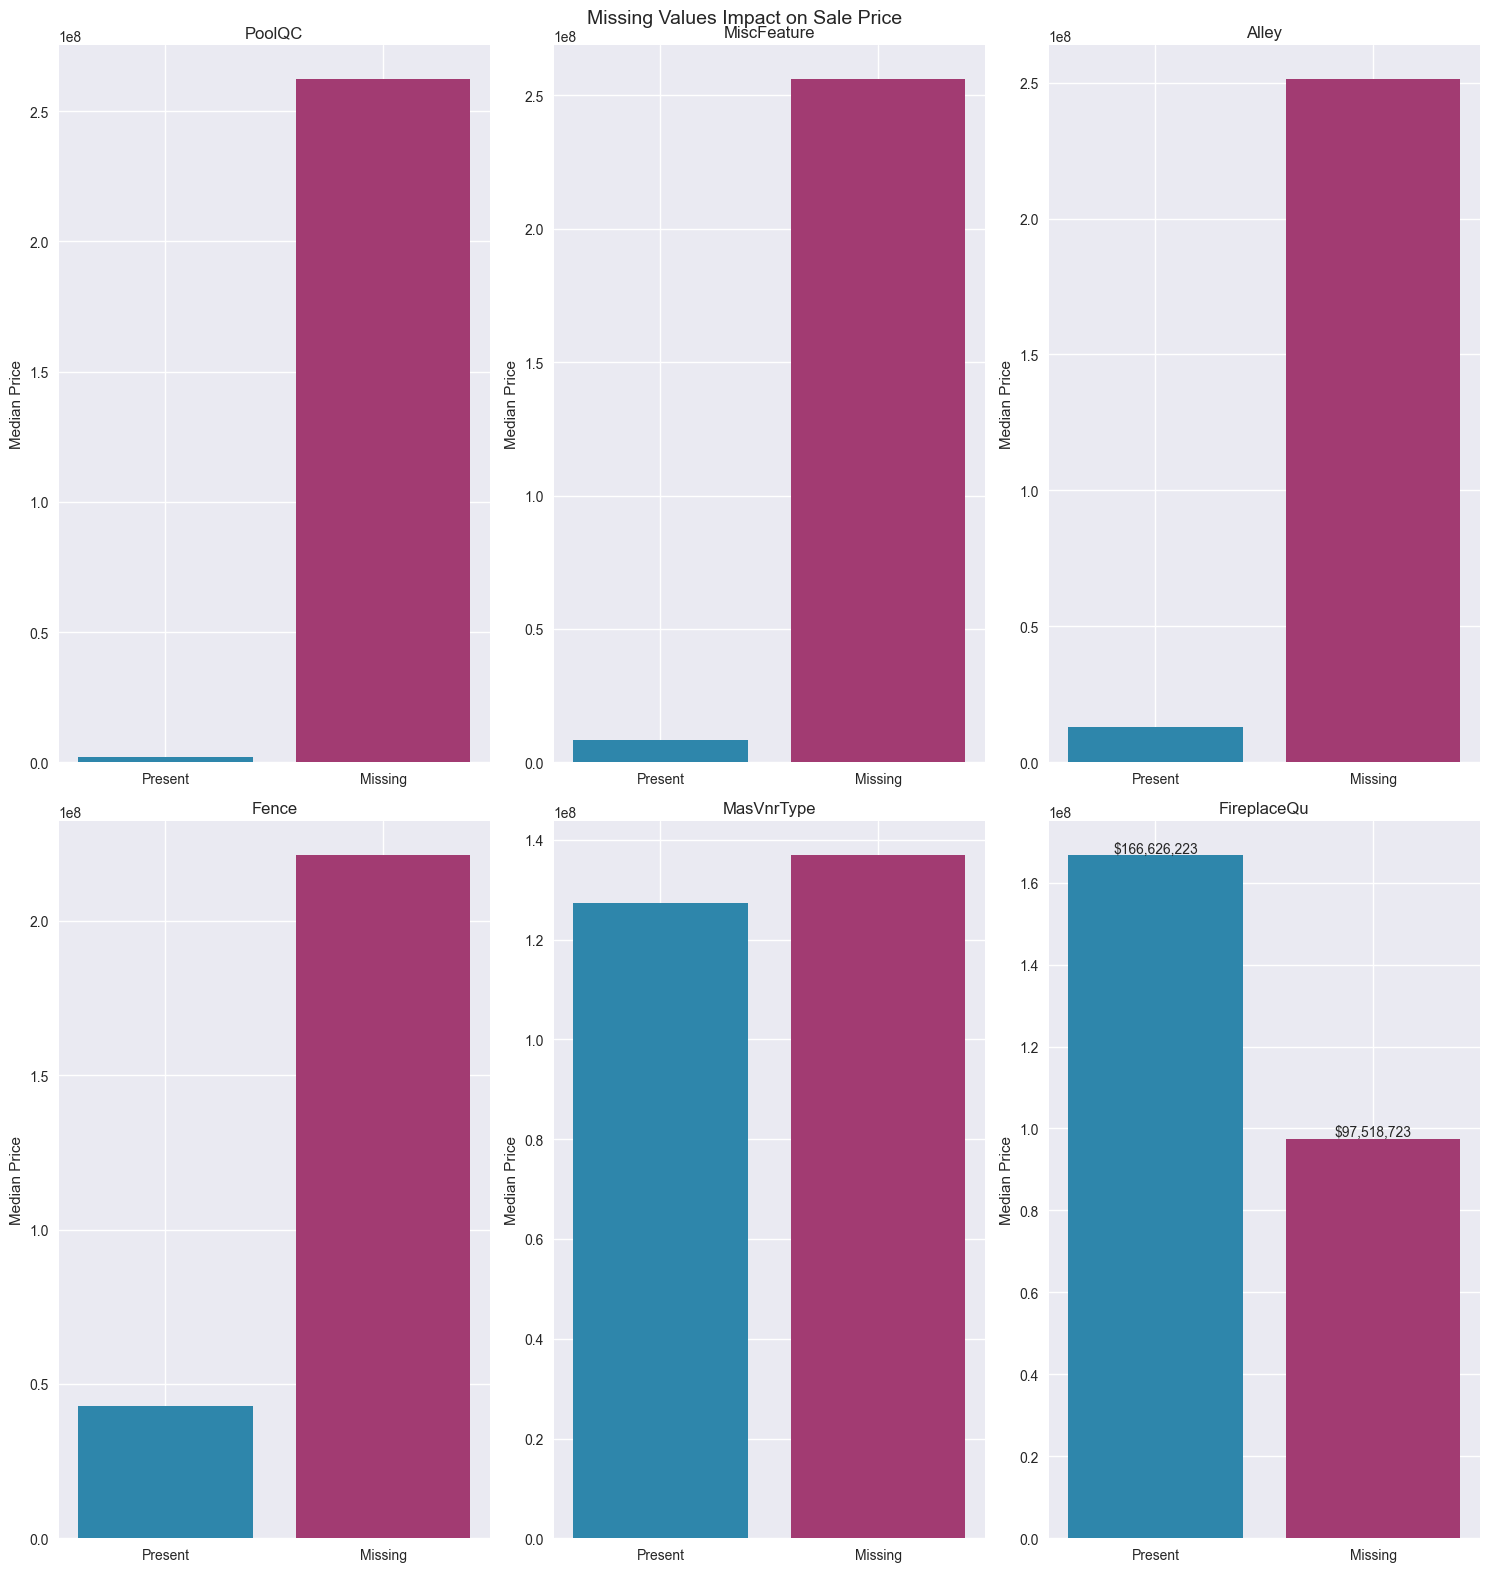

In [17]:
plot_missing_impact(df, features, target='SalePrice' , max_features = 6)

In [14]:
def get_feature_types(df):
    """Categorize features by type"""
    numerical = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical = df.select_dtypes(include=['object']).columns.tolist()
    temporal = [col for col in numerical if 'yr' in col.lower() or  'year' in col.lower()]

    return{
        'numerical': numerical,
        'categorical': categorical,
        'temporal': temporal
    }

def analyze_temporal_trends(df, temporal_features, target= 'SalePrice'):
    if 'YrSold' not in df.columns:
        return
    
     # Year sold trend
    yearly_stats = df.groupby('YrSold')[target].agg(['median','count'])

    plt.figure(figsize=(10,6))
    plt.plot(yearly_stats.index, yearly_stats['median'], marker='o', linewidth = 2)
    plt.title('Median House Price by Year Sold')
    plt.xlabel('Year Sold')
    plt.ylabel('Median Price ($)')
    plt.grid(True, alpha=0.3)

    for year, price in yearly_stats['median'].items():
        plt.annotate(f'${price:,.0f}', (year, price), 
                    textcoords="offset points", xytext=(0,10), ha='center')
        
    plt.tight_layout()
    plt.savefig(VIZ_PATH / 'yearly_trend.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Age analysis for other temporal features
    age_features = [f for f in temporal_features if f != 'YrSold']
    if age_features:
        fig, axes = plt.subplots(1, len(age_features), figsize =(5*len(age_features),5))
        if len(age_features) == 1:
            axes = [axes]
        for i, feature in enumerate(age_features):
            data = df.dropna(subset=[feature]).copy()
            data['age'] = data['YrSold'] - data[feature]

            axes[i].scatter(data['age'], data[target], alpha=0.6, color=COLORS[i])
            axes[i].set_xlabel(f'{feature} Age (years)')
            axes[i].set_ylabel(target)
            axes[i].set_title(f'{feature} Age vs Price')
            axes[i].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(VIZ_PATH / 'age_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

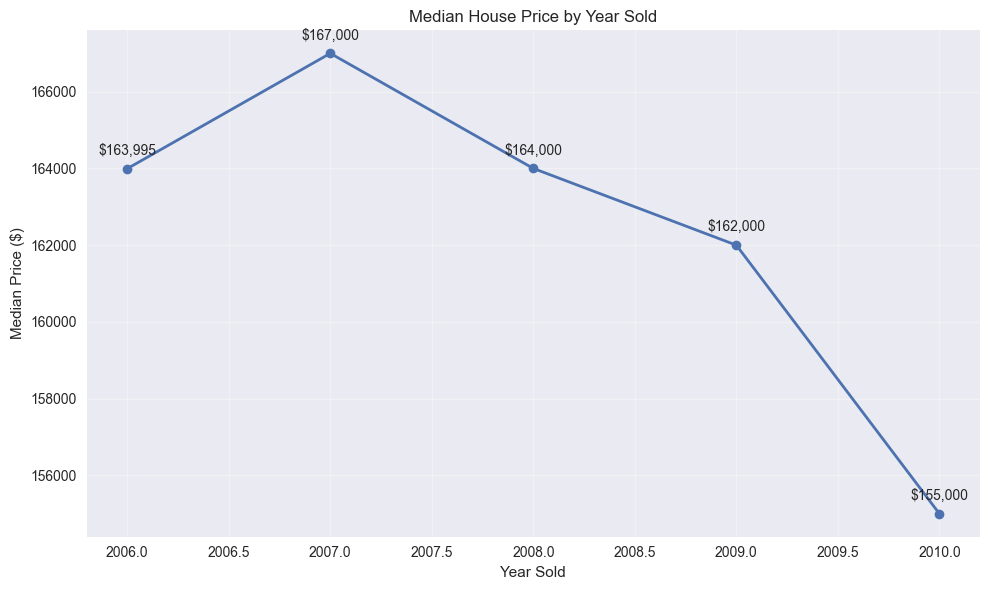

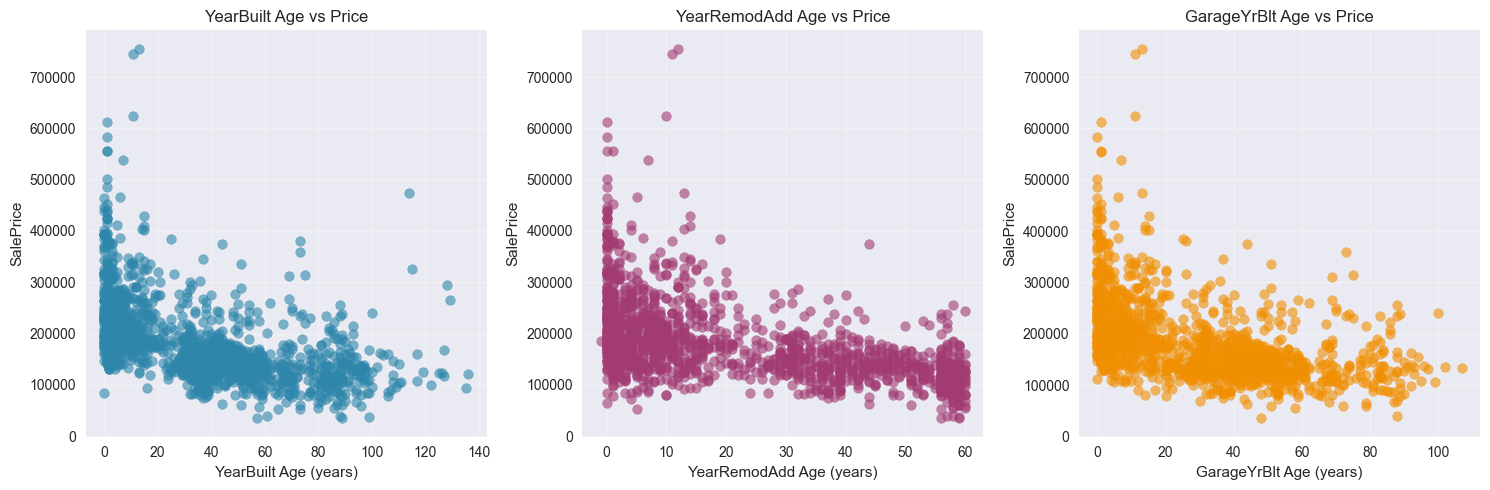

In [15]:
# 1. Get feature types from your dataset
feature_types = get_feature_types(df)

# 2. Extract temporal features
temporal_features = feature_types['temporal']

# 3. Call your temporal analysis function
if temporal_features:
    analyze_temporal_trends(df, temporal_features)
else:
    print("No temporal features found to analyze.")


In [8]:
def compute_correlation_matrix(df, target = "SalePrice", threshold = 0.5):
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numerical_cols].corr()

    plt.figure(figsize=(12,10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig(VIZ_PATH / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    target_corr = corr_matrix[target].abs().sort_values(ascending=False)

    high_corr_features = target_corr[target_corr >= threshold].index.tolist()

    return corr_matrix, target_corr, high_corr_features

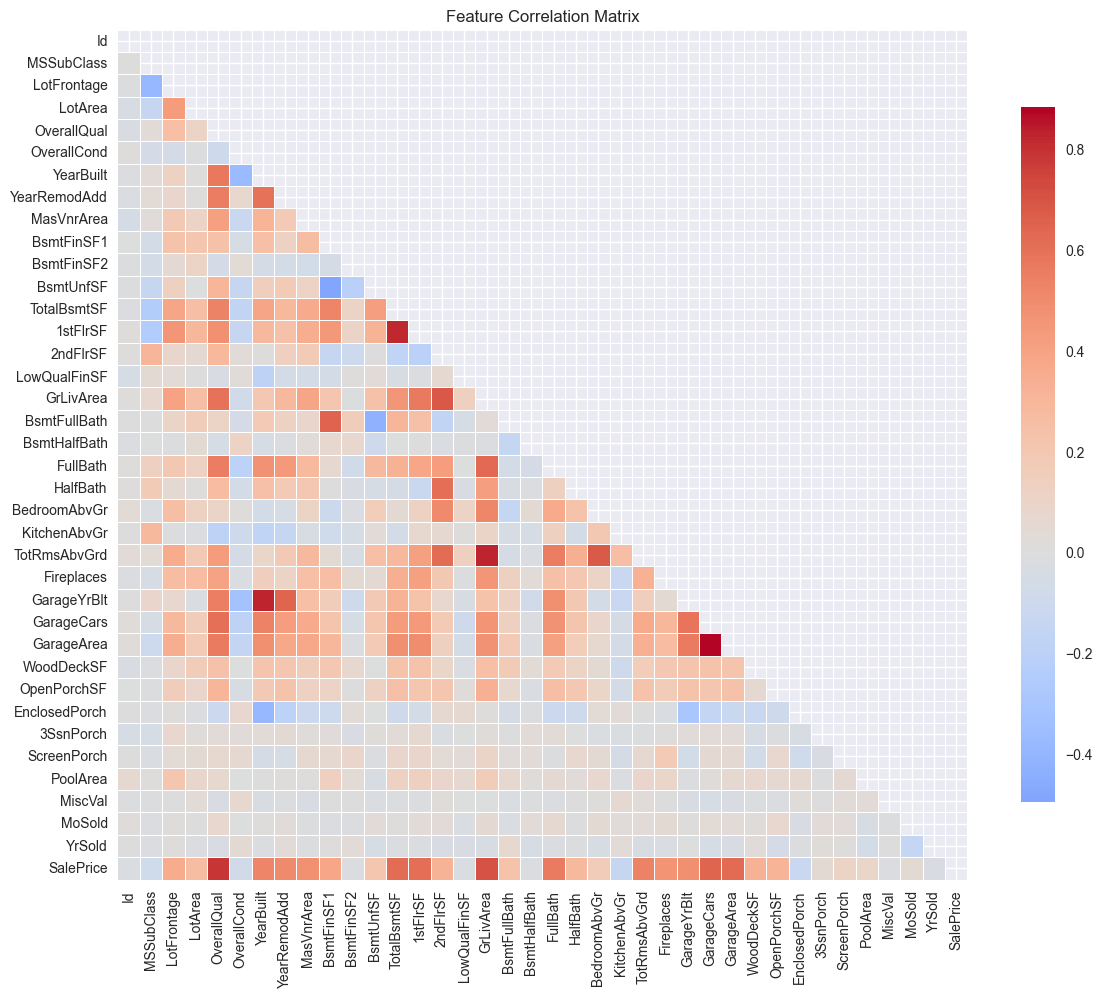

(                     Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
 Id             1.000000    0.011156    -0.010601 -0.033226    -0.028365   
 MSSubClass     0.011156    1.000000    -0.386347 -0.139781     0.032628   
 LotFrontage   -0.010601   -0.386347     1.000000  0.426095     0.251646   
 LotArea       -0.033226   -0.139781     0.426095  1.000000     0.105806   
 OverallQual   -0.028365    0.032628     0.251646  0.105806     1.000000   
 OverallCond    0.012609   -0.059316    -0.059213 -0.005636    -0.091932   
 YearBuilt     -0.012713    0.027850     0.123349  0.014228     0.572323   
 YearRemodAdd  -0.021998    0.040581     0.088866  0.013788     0.550684   
 MasVnrArea    -0.050298    0.022936     0.193458  0.104160     0.411876   
 BsmtFinSF1    -0.005024   -0.069836     0.233633  0.214103     0.239666   
 BsmtFinSF2    -0.005968   -0.065649     0.049900  0.111170    -0.059119   
 BsmtUnfSF     -0.007940   -0.140759     0.132644 -0.002618     0.308159   
 TotalBsmtSF

In [9]:
compute_correlation_matrix(df, target = "SalePrice", threshold = 0.5)

In [9]:
def analyze_categorical_features(df, target = 'SalePrice', max_categories=20):
    categorical_cols = df.select_dtypes(include=['object']).columns

    results = []

    for col in categorical_cols:
        unique_count = df[col].nunique()

        if unique_count <= max_categories: # Skip features with too many categories
            # Calculate median price by category
            category_stats = df.groupby(col)[target].agg(['median','count','std']).reset_index()
            category_stats = category_stats.sort_values('median', ascending=False)

            results.append({
                'feature': col,
                'categories' : unique_count,
                'price_range' : category_stats['median'].max() - category_stats['median'].min(),
                'top_category' : category_stats.iloc[0][col],
                'top_price': category_stats.iloc[0]['median']
            })
        
    return pd.DataFrame(results).sort_values('price_range', ascending=False)

In [10]:
cat_analysis = analyze_categorical_features(df)

In [13]:
def plot_top_categorical_features(df, cat_analysis, target = 'SalePrice', top_n=6):

    top_features = cat_analysis.head(top_n)['feature'].tolist()
    
    fig, axes = plt.subplots(2, 3, figsize =(18,12))
    fig.suptitle('Top Categorical Features Impact on Sale Price', fontsize=16)
    axes = axes.ravel() 

    for i, feature in enumerate(top_features):

        category_medians = df.groupby(feature)[target].median().sort_values(ascending = True)

        ax = axes[i]
        bars = ax.bar(range(len(category_medians)), category_medians.values, color = COLORS[i % len(COLORS)])

        ax.set_title(f'{feature}')
        ax.set_ylabel('Median Price ($)')
        ax.set_xticks(range(len(category_medians)))
        ax.set_xticklabels(category_medians.index, rotation=45, ha='right')

        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'${height:,.0f}', ha='center', va='bottom', fontsize=8)
    for i in range(len(top_features), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig(VIZ_PATH / 'categorical_impact.png', dpi=300, bbox_inches='tight')
    plt.show()

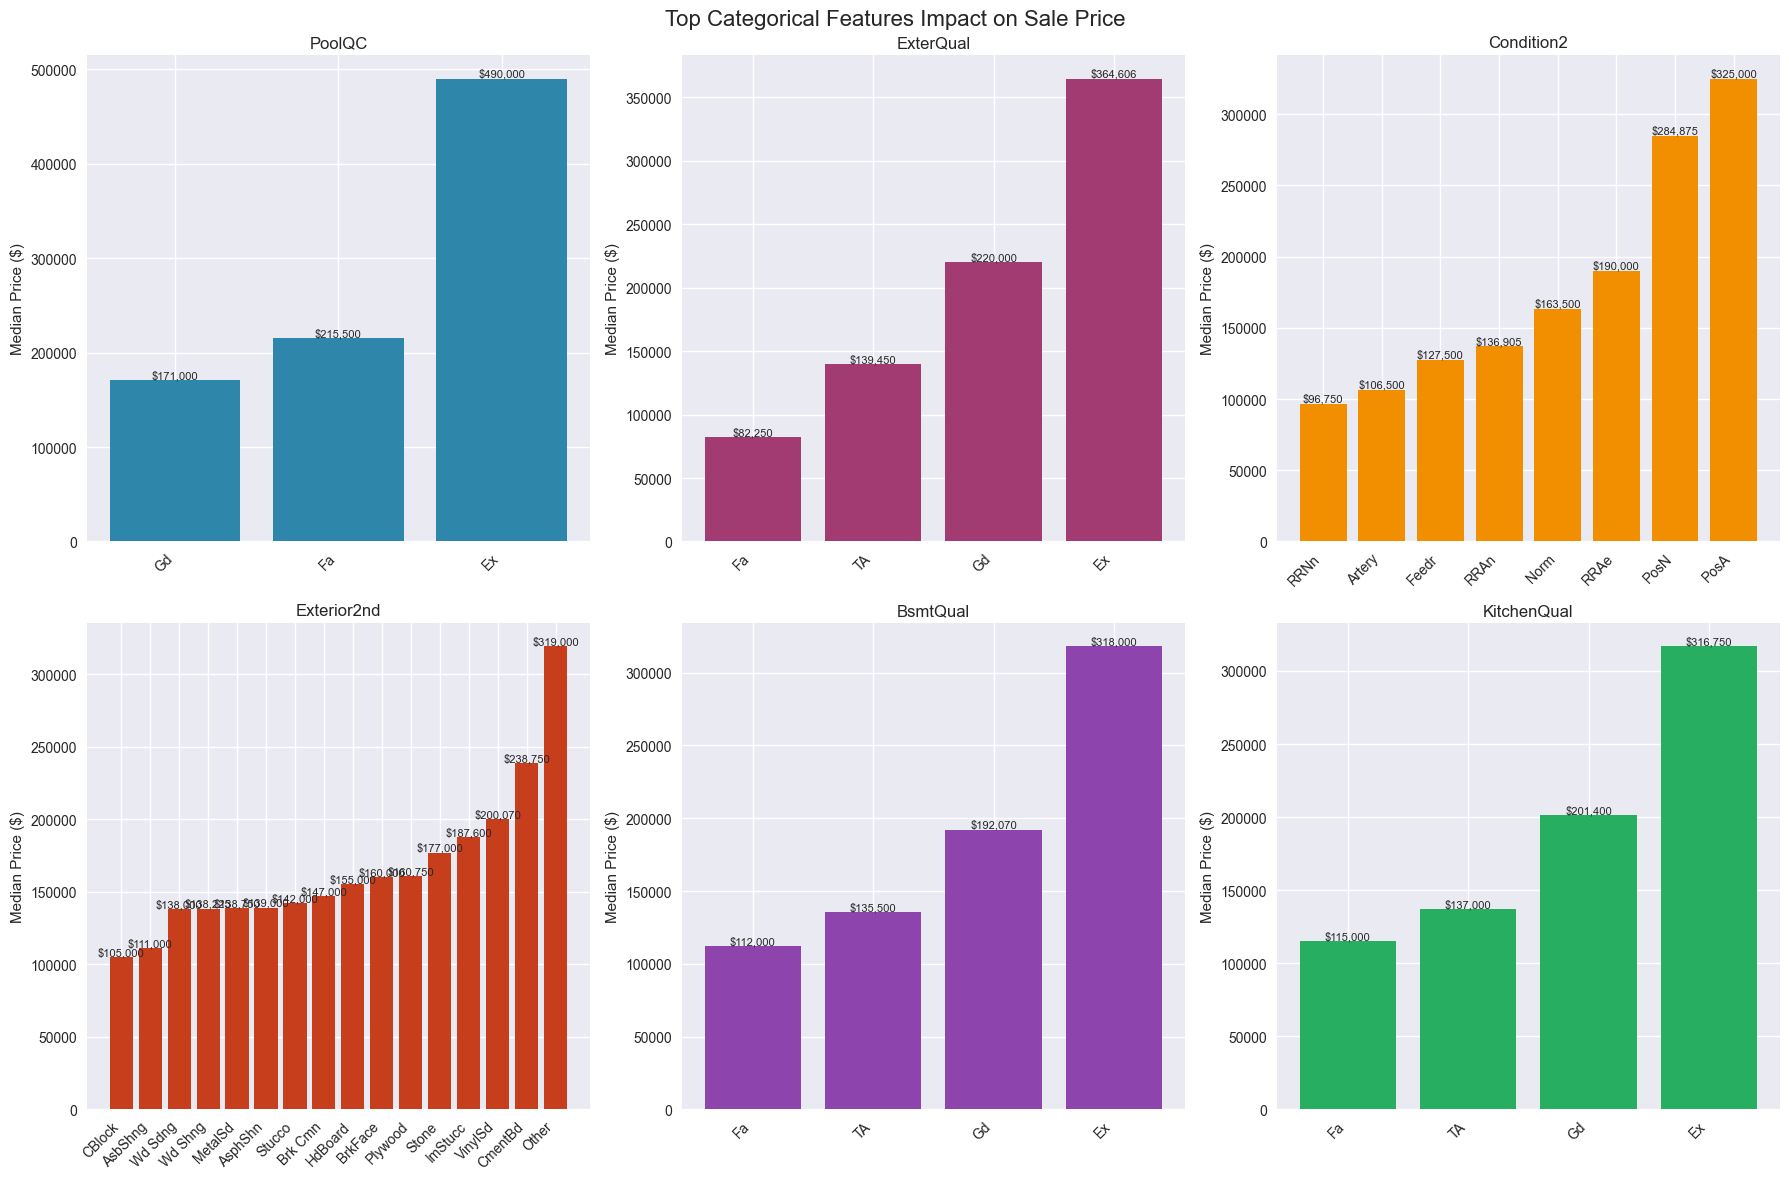

In [14]:
plot_top_categorical_features(df, cat_analysis, target = 'SalePrice', top_n=6)

In [5]:
def detect_outliers(df, features, method='iqr', threshold=1.5):
    """Detect outliers using IQR or Z-score method"""
    outlier_summary = []
    
    for feature in features:
        # Skip non-numerical features
        if df[feature].dtype not in ['int64', 'float64', 'int32', 'float32']:
            continue
            
        data = df[feature].dropna()
        
        if len(data) == 0:  # Skip if no data
            continue
        
        if method == 'iqr':
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            
        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(data))
            outliers = data[z_scores > threshold]
        
        outlier_summary.append({
            'feature': feature,
            'outlier_count': len(outliers),
            'outlier_pct': len(outliers) / len(data) * 100,
            'method': method
        })
    
    return pd.DataFrame(outlier_summary).sort_values('outlier_pct', ascending=False)

In [6]:
detect_outliers(df, features, method='iqr', threshold=1.5)

,feature,outlier_count,outlier_pct,method
0,LotFrontage,88,7.327227,iqr
2,MasVnrArea,96,6.611570,iqr
1,GarageYrBlt,0,0.000000,iqr
